# P1D Mock - Single Script

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy as sp
from scipy.fft import fft, ifft, rfft, irfft
from scipy.stats import binned_statistic 
from scipy import integrate

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

from numpy.polynomial.hermite import hermgauss
from scipy.special import roots_hermite

user inputs? 

size of gaussian grid

spacing of kmode grid

number of bins for rebinning kmodes (default = 40)

delta transform: k0, k1, dv, n, alpha, gamma (??)

redshift evolution: z,z0,a,b

optical depth: c,d

In [12]:

# make gaussian random grid in velocity space
size = 2**20
# default settings are mean 0 and std 1
gaussian_random_field = np.random.default_rng().normal(size=size)


# FFT the gaussian grid into k-space
gaussian_random_field_k = np.fft.rfft(gaussian_random_field) # normalization ?

# make a grid of k-modes (d = spacing of grid)
kmodes = (np.fft.rfftfreq(n=size, d=1) * 2 * np.pi) + 1e-12 # factor of 2pi


# define power measurement
def measure_power(array):
    power = np.abs(array)**2
    return(power)

def measure_scaled_power(array, n, length_scale):
    power = np.abs(array)**2
    scaled_power = power / (n * length_scale)
    return(scaled_power)

# scaled power k is the scaled power measurement of FFT(gaussian field) in k-space
def rebin_kmodes(kmodes, scaled_power_k, num_bins=40):
    statistic, bin_edges, binnumber = binned_statistic(x = kmodes, values = 
                                                   scaled_power_k, 
                                                    statistic = 'mean', bins=num_bins)
    return(statistic, bin_edges, binnumber)


# Define input power spectrum
def power_spectrum(k, k0=0.001, k1 = 0.04, n=0.5, alpha=0.26, gamma=1.8):  #kmodes 
    pk = ( (k / k0)**(n - alpha * np.log(k / k0)) ) / (1 + (k / k1)**gamma)
    pk_i = np.arange(len(pk))
    
    mask = np.isfinite(pk)
    pk_filtered=np.interp(pk_i, pk_i[mask], pk[mask])
    return(pk_filtered)


# Define delta transforms
def delta_transform(k_field, kmodes, dv=1, k0=0.001, k1 = 0.04, n=0.5, alpha=0.26, gamma=1.8):
    delta_b_tilde = k_field * np.sqrt(power_spectrum(kmodes,k0,k1,n,alpha,gamma) / dv)  # multiply k-space field by p(k) expression above
    delta_b = np.fft.irfft(delta_b_tilde)             # inverse rfft back to v-space
    return(delta_b)




# Define Redshift Evolution Factor
def redshift_evolution(z, z0=3, a=58.6, b=-2.82):
    a_z = np.sqrt(a * (((1+z)/(1+z0))**(b)))    
    return(a_z)



# Define Lognormal Transform
def lognormal_transform(delta_b_z, variance):
    n_z = np.exp( (2 * (delta_b_z) - (variance)))
    return(n_z)

# Define Optical Depth Transform
def optical_depth_transform(n_z, z=2.8, z0=3, c=0.55, d=5.1):
    tau_z = c * (((1+z)/(1+z0))**d) * n_z
    return(tau_z)

In [13]:

# Save variance of Delta Field
variance_1d = delta_transform(k_field, kmodes, dv=1).var()

# Redshifted variance
redshifted_variance_1d = variance_1d * redshift_evolution(z,z0,a,b)**2

# Redshifted delta field
delta_b_z = delta_transform(k_field, kmodes, dv=1) * redshift_evolution(z,z0,a,b)

ValueError: operands could not be broadcast together with shapes (0,) (524289,) 

In [6]:
plt.plot(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d), z=2.8))
plt.title(r'$\tau(z) = 0.55 (\frac{1+z}{1+z_0})^{5.1} n(z)$ @ $z=2.8, z_0 = 3$')
plt.ylabel(r'$\tau(z)$')
# plt.xlabel('v-space')

NameError: name 'delta_b_z' is not defined

In [34]:
# for z in z_list:
#     plt.plot(optical_depth_transform(lognormal_transform(delta_transform(gaussian_random_field_k,kmodes,1)*redshift_evolution(z), redshifted_variance_1d)), label='z = '+str(z))
#     plt.legend()
#     plt.title(r'$\tau(z) = 0.55 (\frac{1+z}{1+z_0})^{5.1} n(z)$')
#     plt.ylabel(r'$\tau(z = 1)$')
#     plt.xlabel('v-space')
#     # plt.show()

In [35]:
def plot_optical_depth(z):
    plt.plot(optical_depth_transform(lognormal_transform(delta_transform(gaussian_random_field_k,kmodes,1)*redshift_evolution(z), redshifted_variance_1d)))
    plt.title(r'$\tau(z) = 0.55 (\frac{1+z}{1+z_0})^{5.1} n(z)$')
    plt.ylabel(r'$\tau(z = 1)$')
    plt.xlabel('v-space')

interact(plot_optical_depth, z = widgets.FloatSlider(value=1,
                                                      min=0.1,
                                                      max=10,
                                                      step=0.1))


interactive(children=(FloatSlider(value=1.0, description='z', max=10.0, min=0.1), Output()), _dom_classes=('wi…

<function __main__.plot_optical_depth(z)>


## Smoothing / Flux

(vi) Finally, the flux is: $ F(z) = e^{-\tau(z)} $

In [36]:
def flux(tau):
    F_z = np.exp(-(tau))
    return(F_z)

Text(0, 0.5, 'flux')

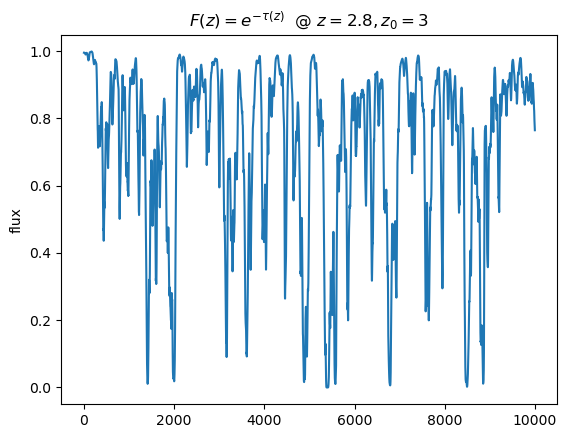

In [37]:
plt.plot(flux(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d)))[:10000])
plt.title(r'$ F(z) = e^{-\tau(z)} $  @ $z=2.8, z_0 = 3$')
plt.ylabel('flux')
# plt.xlabel('v-space')



Text(0.5, 0, 'v-space')

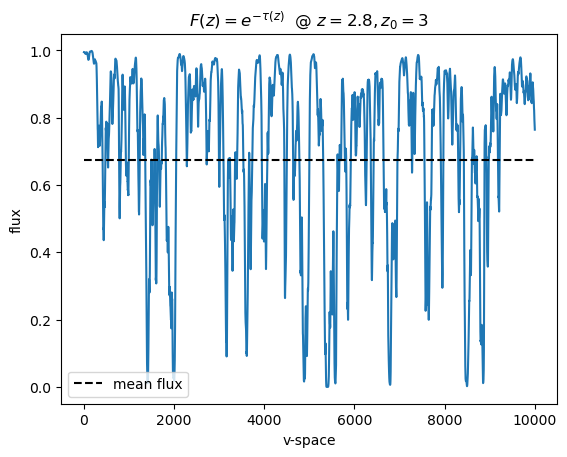

In [38]:
plt.plot(flux(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d)))[:10000])
plt.title(r'$ F(z) = e^{-\tau(z)} $  @ $z=2.8, z_0 = 3$')
plt.ylabel('flux')
plt.hlines(y=flux(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d))).mean(), xmin=0,xmax=10000, color='black', ls='--',label='mean flux')
plt.legend()
plt.xlabel('v-space')

In [39]:
def plot_flux(z):
    plt.plot(flux(optical_depth_transform(lognormal_transform(delta_transform(gaussian_random_field_k,kmodes,1)*redshift_evolution(z), redshifted_variance_1d)))[:10000])
    plt.title(r'$ F(z) = e^{-\tau(z)} $')
    plt.ylabel('flux')
    plt.xlabel('v-space')

interact(plot_flux, z = widgets.FloatSlider(value=1,
                                                      min=0.1,
                                                      max=10,
                                                      step=0.1))


interactive(children=(FloatSlider(value=1.0, description='z', max=10.0, min=0.1), Output()), _dom_classes=('wi…

<function __main__.plot_flux(z)>

In [40]:
def plot_flux(z, z0, c, d, k0,k1,n,alpha,gamma,dv,a,b):
    v_field = np.random.default_rng(10).normal(size=2**20)
    k_field = np.fft.rfft(v_field) # * 2 * np.pi ?
    kmodes = (np.fft.rfftfreq(n=size, d=1) * 2 * np.pi) 

    delta_z = delta_transform(k_field, kmodes, dv, k0,k1,n,alpha,gamma) * redshift_evolution(z,z0,a,b)
    variance = (delta_transform(k_field, kmodes, dv, k0,k1,n,alpha,gamma).var()) * redshift_evolution(z,z0,a,b)**2
    
    Flux = flux(optical_depth_transform(lognormal_transform(delta_z,variance),z,z0,c,d))

    plt.plot(Flux[:10000])
    
    plt.title(r'$ F(z) = e^{-\tau(z)} $')
    plt.ylabel('flux')
    # plt.xlabel('v-space')



interact(plot_flux, 
         dv = widgets.FloatSlider(value=1,
                                 min=1,
                                 max=10,
                                 step=0.1),
         k0 = widgets.FloatSlider(value=0.001,
                                min=0.00001,
                                max=0.1,
                                step=0.00001), 
         k1 = widgets.FloatSlider(value=0.04,
                                 min=0.001,
                                 max=0.1,
                                 step=0.001),
         n = widgets.FloatSlider(value=0.5,
                                min=0.01,
                                max = 10,
                                step=0.01),
         alpha = widgets.FloatSlider(value=0.26,
                                min=0.01,
                                max = 1,
                                step = 0.01),
         gamma = widgets.FloatSlider(value=1.8,
                                min=0.01,
                                max = 3,
                                step = 0.01),
         a = widgets.FloatSlider(value=58.6,
                                min=0.1,
                                max = 100,
                                step=0.1),
         b = widgets.FloatSlider(value=-2.82,
                                min=-5,
                                max = 5,
                                step = 0.1),
         z = widgets.FloatSlider(value=1,
                                min=0.1,
                                max=5,
                                step=0.01), 
         z0 = widgets.FloatSlider(value=3,
                                 min=0.1,
                                 max=10,
                                 step=0.01),
         c = widgets.FloatSlider(value=0.55,
                                min=0.01,
                                max = 1,
                                step=0.01),
         d = widgets.FloatSlider(value=5.1,
                                min=0.1,
                                max = 10,
                                step = 0.1))

interactive(children=(FloatSlider(value=1.0, description='z', max=5.0, min=0.1, step=0.01), FloatSlider(value=…

<function __main__.plot_flux(z, z0, c, d, k0, k1, n, alpha, gamma, dv, a, b)>

The function *quad* is provided to integrate a function of one variable between two points. The points can be 
 ($\pm \inf$, or $\pm$ inf) to indicate infinite limits. 
 
For example: 

$$ I = \int_0^{4} x^2 dx $$



In [41]:
integrand = lambda x: x**2

integrate.quad(integrand, 0, 4)[0]

21.333333333333336

For example: 

$$ I = \int_0^{\infty} e^{-x} dx $$

In [42]:
integrand = lambda x: np.exp(-x)

integrate.quad(integrand, 0, np.inf)[0]

1.0000000000000002

Now try a simplified version of the flux equation: 

$$ I = \int_0^{\infty} e^x dx $$

In [43]:
integrand = lambda x: np.exp((-x**2 / 2) - (np.exp(2 * x)))

integrate.quad(integrand, -np.inf, np.inf)[0]

/tmp/ipykernel_1952309/270448057.py:1: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-x**2 / 2) - (np.exp(2 * x)))


1.033122862964228

### Mean Flux

Them mean flux and power spectrum of these mocks can be analytically computed. Using one-point probability of the base Gaussian random field, $\delta$, we can write down the following integral for the mean flux: 

$$ \bar{F}(z) = \frac{1}{\sigma \sqrt{2\pi}} \int_{-\infty}^{\infty} \exp{[-\frac{\delta^2}{2 \sigma^2} - x(z) e^{2 a(z)\delta}]d\delta} $$

where, 

$$ x(z) \equiv 0.55 (\frac{1+z}{1+z_0})^{5.1} e^{-a^2(z)\sigma^2} $$

In [44]:
def prefactor(variance):
    prefactor = 1 / (np.sqrt(variance) * np.sqrt(2 * np.pi))
    return(prefactor)

def x_z(z, variance, z0 = 3):
    x_z = 0.55 * (((1+z)/(1+z0))**5.1) * (np.exp(-((redshift_evolution(z,z0))**2) * variance))
    return(x_z)

def mean_flux(z, variance, z0=3):
    integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))
    integral = integrate.quad(integrand, -np.inf, np.inf)[0]
    value = prefactor(variance) * integral
    return(value)

In [45]:
mean_flux(z=2.8, variance=variance_1d, z0=3)

/tmp/ipykernel_1952309/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


0.6737381316528798

In [46]:
test_flux = flux(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d)))
test_flux.mean()

0.674172772986657

#### Mean Flux vs Redshift

In [47]:
z_list = np.array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6,
       3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])
# z_list = np.array(z_list)

In [48]:
flux_list = []
for i in z_list:
    flux_list.append(mean_flux(z=i,variance=variance_1d, z0=3))
    # flux_list = np.array(flux_list)

/tmp/ipykernel_1952309/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


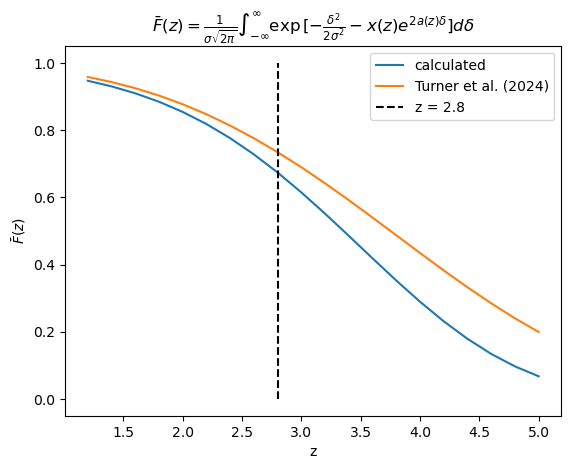

In [49]:
plt.plot(z_list, flux_list, label = 'calculated')

plt.plot(z_list, np.exp(-2.46e-3*(1+z_list)**3.62), label='Turner et al. (2024)')

plt.title(r'$\bar F(z) = \frac{1}{\sigma \sqrt{2 \pi}} \int_{-\infty}^{\infty}\exp{[-\frac{\delta^2}{2 \sigma^2}-x(z)e^{2 a(z)\delta}]d\delta}$')
plt.xlabel('z')
plt.ylabel(r'$\bar F(z) $')
plt.vlines(x=2.8, ymin=0, ymax=1, ls='--', color = 'black',label='z = 2.8')
plt.legend()
plt.rcParams["figure.figsize"] = (6,4)


## Measure Power

The next test would be to measure the power spectrum, using the ratio of flux / mean flux (analytical), and comparing to the power of the gaussian random field. 

Define flux power spectrum (FPS) as: 

$$ \delta_F \equiv \frac{F - \langle F \rangle}{\langle F \rangle} $$

Where $\langle F \rangle$ is the average flux ($\overline F$)

In [50]:
def delta_F(z,variance,input_flux,z0=3):
    f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    return(delta_f)

def delta_F_k(z,variance,input_flux,z0=3):
    f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    delta_f_tilde = np.fft.fft(delta_f)
    return(delta_f_tilde)

In [51]:
delta_f = delta_F(z=2.8, variance=variance_1d, input_flux=test_flux, z0=3)

/tmp/ipykernel_1169640/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


$$ P_F(k) = \delta_f(k) * \delta_f(k) $$
where $\delta_F(k)$ is the Fourier transform of the flux overdensity.

In [52]:
def P_F(delta_f):
    delta_f_tilde = np.fft.fft(delta_f)
    P_F = np.abs(delta_f_tilde)**2
    return(P_F)

In [53]:
# make a grid of k-modes, using same dims as the field of measured power
# d = spacing of the grid

test_power = P_F(delta_f)
test_power2 = measure_scaled_power(delta_F_k(z=2.8, input_flux=test_flux, variance=variance_1d, z0=3), n=test_power.size, length_scale=1)
kmodes2 = (np.fft.rfftfreq(n=2*(test_power.size), d=1) * 2 * np.pi) + 1e-12 

# print('Number of kmodes: '+ str(kmodes2.size))
# print(kmodes2)

/tmp/ipykernel_1169640/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


/tmp/ipykernel_1169640/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


Text(0, 0.5, '$P_F(k)$')

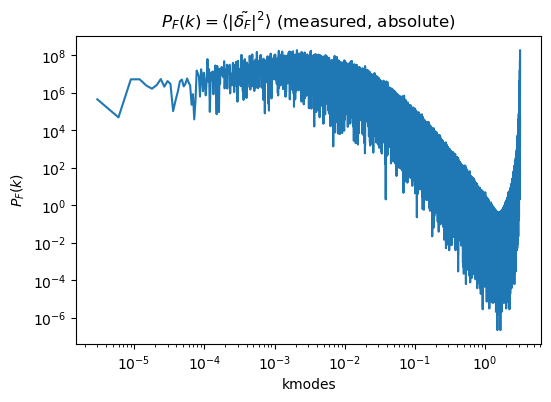

In [54]:
plt.loglog(kmodes2[1:], measure_power(delta_F_k(z=2.8, input_flux=test_flux, variance=variance_1d, z0=3)))
plt.title(r'$P_F(k) = \langle | \tilde{\delta_F} |^2 \rangle$ (measured, absolute)')
plt.xlabel('kmodes')
plt.ylabel(r'$P_F(k)$')

/tmp/ipykernel_1169640/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


Text(0, 0.5, '$P_F(k)$')

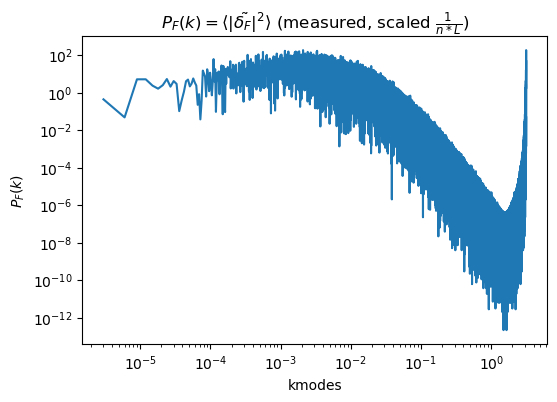

In [55]:
plt.loglog(kmodes2[1:], measure_scaled_power(delta_F_k(z=2.8, input_flux=test_flux, variance=variance_1d, z0=3), n=test_power.size, length_scale=1))
plt.title(r'$P_F(k) = \langle | \tilde{\delta_F} |^2 \rangle$ (measured, scaled $\frac{1}{n * L}$)')
plt.xlabel('kmodes')
plt.ylabel(r'$P_F(k)$')

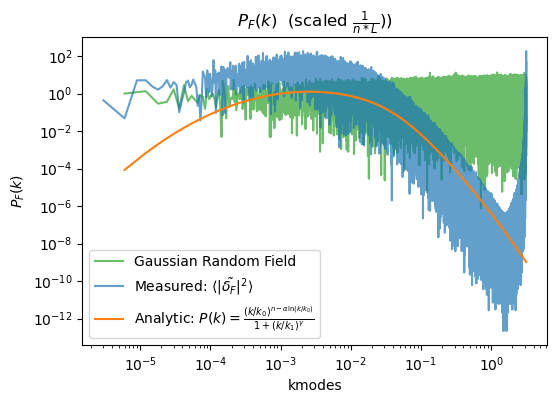

In [56]:
plt.loglog(kmodes[1:], measure_scaled_power(gaussian_random_field_k[1:], n=size, length_scale=1), alpha=0.7, label='Gaussian Random Field', color='tab:green')
plt.loglog(kmodes2[1:], test_power2, label = r'Measured: $\langle | \tilde{\delta_F} |^2 \rangle$', alpha=0.7, color='tab:blue')
plt.loglog(kmodes[1:],power_spectrum(kmodes[1:]), label = r'Analytic: $P(k) = \frac{(k / k_0)^{n - \alpha \ln(k/k_0)}}{1 + (k/k_1)^{\gamma}}$', color='tab:orange')

plt.title(r'$P_F(k)$  (scaled $\frac{1}{n * L}$))')
plt.xlabel('kmodes')
plt.ylabel(r'$P_F(k)$')
plt.legend()

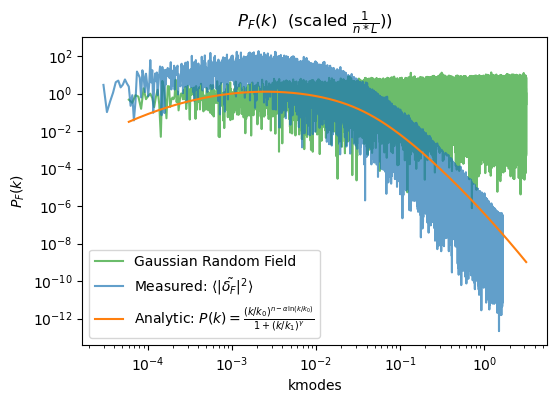

In [57]:
plt.loglog(kmodes[10:548576], measure_scaled_power(gaussian_random_field_k[10:548576], n=size, length_scale=1), alpha=0.7, label='Gaussian Random Field', color='tab:green')
plt.loglog(kmodes2[10:548576], test_power2[10:548576], alpha=0.7, label = r'Measured: $\langle | \tilde{\delta_F} |^2 \rangle$', color='tab:blue')
plt.loglog(kmodes[10:548576],power_spectrum(kmodes[10:548576]), label = r'Analytic: $P(k) = \frac{(k / k_0)^{n - \alpha \ln(k/k_0)}}{1 + (k/k_1)^{\gamma}}$', color='tab:orange')

plt.title(r'$P_F(k)$  (scaled $\frac{1}{n * L}$))')
plt.xlabel('kmodes')
plt.ylabel(r'$P_F(k)$')
plt.legend()

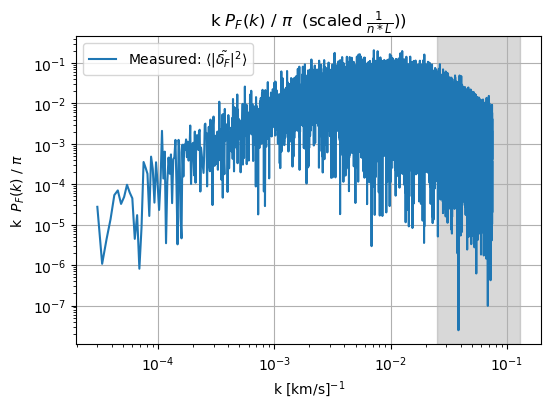

In [58]:
plt.loglog(kmodes2[10:25000], (kmodes2[10:25000]/np.pi)*test_power2[10:25000], label = r'Measured: $\langle | \tilde{\delta_F} |^2 \rangle$', color='tab:blue')

plt.title(r'k $P_F(k)$ / $\pi$  (scaled $\frac{1}{n * L}$))')
plt.xlabel('k [km/s$]^{-1}$')
plt.ylabel(r'k  $P_F(k)$ / $\pi$')
plt.legend()
plt.axvspan(0.025, 0.13, alpha=0.3, color='grey')
plt.rcParams["figure.figsize"] = (9,5)
plt.grid(True)

##### try rebinning

statistic shape:  1000
bin edges shape:  1001
bim number shape: 24990


(0.0001, 0.1)

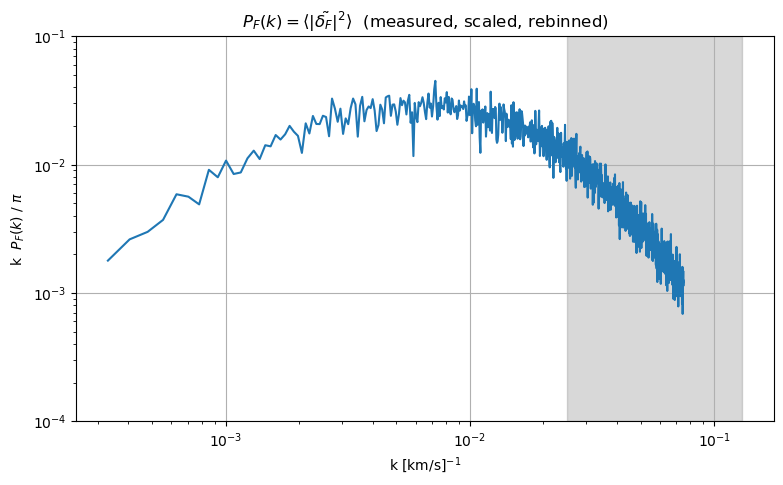

In [59]:
# rebin power normally, then kp/pi first when plot


statistic_test, bin_edges_test, binnumber_test = binned_statistic(x = kmodes2[10:25000], values = 
                                                    test_power2[10:25000], 
                                                    statistic = 'mean', bins=1000)
print("statistic shape:  " + str(statistic_test.shape[0])) # The values of the selected statistic in each bin, mean here
print("bin edges shape:  " + str(bin_edges_test.shape[0])) # Return the bin edges (length(statistic)+1).
print("bim number shape: " + str(binnumber_test.shape[0])) # Indices of the bins (corresponding to bin_edges) 
                                                       # in which each value of x belongs. Same length as values 
    
    
    
plt.loglog(bin_edges_test[4:], (bin_edges_test[4:]/np.pi)*statistic_test[3:])
plt.title(r'$P_F(k) = \langle | \tilde{\delta_F} |^2 \rangle$  (measured, scaled, rebinned)')
plt.ylabel(r'k  $P_F(k)$ / $\pi$')
plt.xlabel('k [km/s$]^{-1}$')
plt.rcParams["figure.figsize"] = (9,5)
plt.axvspan(0.025, 0.13, alpha=0.3, color='grey')
plt.grid(True)
plt.ylim(10e-5,10e-2)

statistic shape:  1000
bin edges shape:  1001
bim number shape: 24990


(0.0001, 0.1)

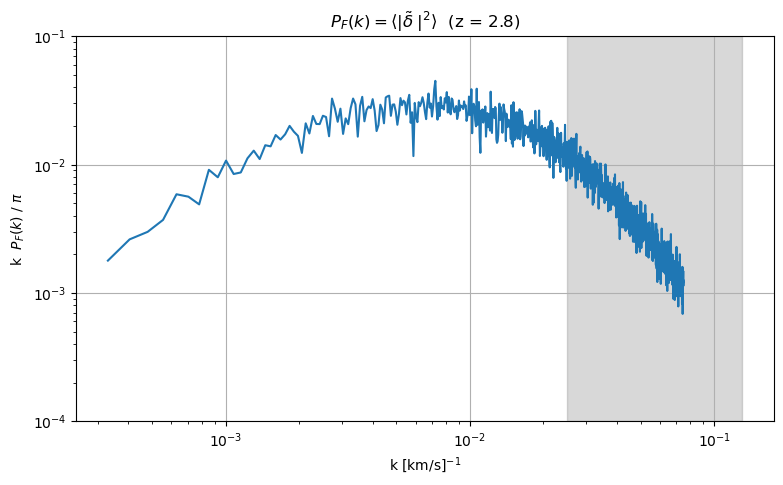

In [60]:
# rescale as kp/pi first when binning, then plot the rebinned data

statistic_test, bin_edges_test, binnumber_test = binned_statistic(x = kmodes2[10:25000], values = 
                                                    test_power2[10:25000], 
                                                    statistic = 'mean', bins=1000)
print("statistic shape:  " + str(statistic_test.shape[0])) # The values of the selected statistic in each bin, mean here
print("bin edges shape:  " + str(bin_edges_test.shape[0])) # Return the bin edges (length(statistic)+1).
print("bim number shape: " + str(binnumber_test.shape[0])) # Indices of the bins (corresponding to bin_edges) 
                                                       # in which each value of x belongs. Same length as values 
    
plt.loglog(bin_edges_test[4:], (bin_edges_test[4:]/np.pi)*statistic_test[3:])
plt.title(r'$P_F(k) = \langle | \tilde{\delta}_ |^2 \rangle$  (z = 2.8)')
plt.ylabel(r'k  $P_F(k)$ / $\pi$')
plt.xlabel('k [km/s$]^{-1}$')
plt.rcParams["figure.figsize"] = (9,5)
plt.axvspan(0.025, 0.13, alpha=0.3, color='grey')
plt.grid(True)
plt.ylim(10e-5,10e-2)

## Test Gauss-Hermite Quadrature Integration

$$ \int_{-\infty}^{\infty} e^{-x^2}dx \approx \Sigma_{i=1}^n  w_i f(x_i) $$

where, 

$ n = $ number of sample points,

$x_i = $ roots of Hermite Polynomial

$w_i = $ associated weights

#### numpy.polynomial.hermite.hermgauss

Computes the sample points and weights for Gauss-Hermite quadrature. These sample points and weights will correctly integrate polynomials of degree $2 * deg -1$ or less over the interval [-inf, inf], with weight function $f(x) = exp(x^2)$

$$ \bar{F}(z) = \frac{1}{\sigma \sqrt{2\pi}} \int_{-\infty}^{\infty} \exp{[-\frac{\delta^2}{2 \sigma^2} - x(z) e^{2 a(z)\delta}]d\delta} $$

where, 

$$ x(z) \equiv 0.55 (\frac{1+z}{1+z_0})^{5.1} e^{-a^2(z)\sigma^2} $$

To modify for Gauss-Hermite quadrature: 

$$ I = \int_{-\infty}^{\infty} e^{- \frac{\delta^2}{2 \sigma^2}} \times e^{-x(z)\times e^{2 a(z) \delta}} d\delta$$

$$ I = \int_{-\infty}^{\infty} \exp ( - \frac{\delta^2}{2 \sigma^2} - x(z) \times e^{2 a(z) \delta} )  d\delta $$

Simplify by substituting $\alpha = \frac{1}{2 \sigma^2}$ and $\beta = x(z)$. Then: 

$$ I = \int_{-\infty}^{\infty} \exp(-\alpha \delta^2 - \beta e^{2 a(z)\delta}) d\delta $$

In the Gauss-Hermite quadrature framework, we need the form of $\int_{-\infty}^{\infty} e^{-x^2}f(x)dx$, so we make the changes: 

$$ \delta = \sqrt{2 \sigma^2}x $$

and

$$ d\delta = \sqrt{2 \delta^2}dx $$

then, substituting:

$$ I = \int_{-\infty}^{\infty} \exp(-\frac{(\sqrt{2\sigma^2}x)^2}{2\sigma^2} - \beta e^{2 a(z) \sqrt{2\sigma^2}x})\times \sqrt{2 \sigma^2}x dx$$

$$ I = \sqrt{2 \sigma^2} \int_{-\infty}^{\infty} \exp(-x^2 - \beta e^{2 a(z) \sqrt{2\sigma^2}x}) dx $$

Then, we need to idenltify f(x) for the approximation: 

$$ f(x) = \exp(-\beta e^{2 a(z)\sqrt{2\sigma^2}x}) $$

And in the form of Gauss-Hermite quadrature, we can rewrite the integral: 

$$ \int_{-\infty}^{\infty} e^{x^2} f(x)dx \approx \Sigma_{i=1}^{N}w_i \times f(x_i) $$

becomes:

$$ I \approx \sqrt{2\sigma^2} \Sigma_{i=1}^{N}w_i \times \exp(- \beta e^{2 a(z) \sqrt{2\sigma^2}x_i}) $$

where $x_i$ and $w_i$ are the nodes and weights of for Gauss-Hermite quadrature.

In [52]:
# use the approximation form above, resubmitting the substitution 
# Beta, adding the prefactor, and using n=10

def gh_mean_flux(n, z, variance, z0=3, a=58.6, b=-2.82):
    # Parameters
    sigma = np.sqrt(variance_1d)
    a_z = redshift_evolution(z,z0,a,b)
    beta = x_z(z, variance, z0)

    # Number of Gauss-Hermite nodes
    N = n

    # Compute Gauss-Hermite nodes and weights
    nodes, weights = hermgauss(N)

    # Transform nodes for the given problem
    transformed_nodes = np.sqrt(2 * sigma**2) * nodes

    # Compute the function values
    function_values = np.exp(-beta * np.exp(2 * a_z * transformed_nodes))

    # Compute the integral approximation
    integral_approximation = np.sqrt(2 * sigma**2) * np.sum(weights * function_values)

    # multiply by prefactor
    gh_prefactor = 1 / np.sqrt(2 * np.pi * variance)
    integral_approximation = integral_approximation * gh_prefactor
    
    return(integral_approximation)

In [53]:
# Compare to mean flux function: 

print('GH approximation: ' + str(gh_mean_flux(n=10, z=2.8, variance=variance_1d)))
print('Analytic:         ' + str(mean_flux(z=2.8, variance=variance_1d)))
print("Difference:      " + str(np.absolute(gh_mean_flux(n=10, z=2.8, variance=variance_1d)) - mean_flux(z=2.8, variance=variance_1d)))

GH approximation: 0.6736318309321093
Analytic:         0.6737381316528798
Difference:      -0.00010630072077044694


/tmp/ipykernel_1952309/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


/tmp/ipykernel_1952309/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


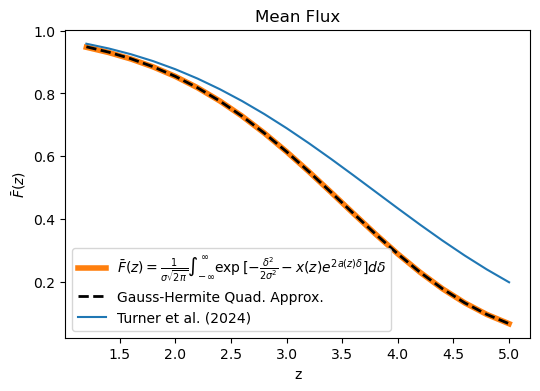

In [54]:
z_list = np.array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6,
       3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])

mean_flux_list = []
gh_flux_list = []
difference_list = []
for i in z_list:
    mean_flux_list.append(mean_flux(z=i,variance=variance_1d, z0=3))
    gh_flux_list.append(gh_mean_flux(n=10, z=i, variance=variance_1d, z0=3))
    difference_list.append(np.absolute(mean_flux(z=i,variance=variance_1d, z0=3) - gh_mean_flux(n=10, z=i, variance=variance_1d, z0=3)))
    
plt.plot(z_list, mean_flux_list, label = r'$\bar F(z) = \frac{1}{\sigma \sqrt{2 \pi}} \int_{-\infty}^{\infty}\exp{[-\frac{\delta^2}{2 \sigma^2}-x(z)e^{2 a(z)\delta}]d\delta}$', linewidth=4, color = 'tab:orange')
plt.plot(z_list, gh_flux_list, label = 'Gauss-Hermite Quad. Approx.', ls = '--', linewidth=2, color='black')
plt.plot(z_list, np.exp(-2.46e-3*(1+z_list)**3.62), label='Turner et al. (2024)', color = 'tab:blue')


plt.title('Mean Flux')
plt.xlabel('z')
plt.ylabel(r'$\bar F(z) $')
# plt.vlines(x=2.8, ymin=0, ymax=1, ls='dotted', color = 'black',label='z = 2.8')
plt.legend()
plt.rcParams["figure.figsize"] = (7,4)


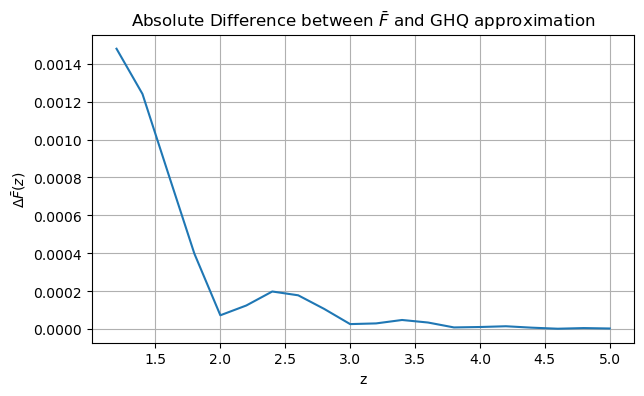

In [103]:
plt.plot(z_list, difference_list)
    
plt.title(r'Absolute Difference between $\bar{F}$ and GHQ approximation')
plt.xlabel('z')
plt.ylabel(r'$\Delta \bar F(z) $')
plt.grid(True)

### Now try with eq. 29

$$ 1 + \xi_F(v) = \int e^{-y^2} \frac{1}{\pi\bar{F}(z)} \exp[-x(z)(e^{2a\delta_1}+e^{2a\delta_2})]dy $$

correlation function of gaussian field

$$ \xi_G(v) = \exp(\frac{-v^2}{2 \sigma^2}) $$

In [88]:
from scipy.special import roots_hermite

def ghq_eq29(n, z, variance, v_field, z0=3, a=58.6, b=-2.82): 
    # Define necessary internal functions

    sigma = np.sqrt(variance)  # Standard deviation of the Gaussian random field
    a = redshift_evolution(z, z0, a, b)
    xz = x_z(z, variance, z0)
    F_bar = gh_mean_flux(n, z, variance, z0, a, b)

    # Define the correlation function based on the provided expression
    def cor_func_test(v_field, variance):
        return np.exp(-np.array(v_field)**2 / (2 * variance))

    # Define the matrix L based on the given description and correlation function
    def get_L(sigma, xi_G_v):
        L = np.zeros((2, 2))
        L[0, 0] = sigma
        L[1, 0] = xi_G_v / sigma
        L[1, 1] = sigma * np.sqrt(1 - (xi_G_v**2 / sigma**4))
        return L

    # Compute delta_1 and delta_2
    def compute_deltas(L, y):
        delta = np.sqrt(2) * np.dot(L, y)
        delta_1 = delta[0]
        delta_2 = delta[1]
        return delta_1, delta_2

    # Define the function f(y) based on the given expression
    def f(y, L, xz, F_bar, a):
        delta_1, delta_2 = compute_deltas(L, y)
        exponent = -xz * (np.exp(2 * a * delta_1) + np.exp(2 * a * delta_2))
        return (np.pi / F_bar) * np.exp(exponent)

    # Use Gauss-Hermite quadrature to estimate the integral
    def gauss_hermite_quadrature(xz, F_bar, a, sigma, variance, n):
        # Get the Gauss-Hermite quadrature points and weights
        points, weights = roots_hermite(n)

        # Initialize the sum
        integral_sum = 0.0

        # Iterate over each quadrature point and weight
        for i in range(n):
            y = np.array([points[i], points[i]])  # Considering 2D case with y_i values
            w = weights[i]

            # Compute xi_G(v) for the given quadrature point y
            xi_G_v = cor_func_test([points[i]], variance)[0]

            # Update matrix L with the current xi_G_v
            L = get_L(sigma, xi_G_v)

            # Evaluate the function f(y)
            f_val = f(y, L, xz, F_bar, a)

            # Update the integral sum with the weighted function value
            integral_sum += w * f_val

        # Return the computed integral sum
        return integral_sum

    # Call the Gauss-Hermite quadrature function and return the result
    result = gauss_hermite_quadrature(xz, F_bar, a, sigma, variance, n)
    return result

In [91]:
test_result = ghq_eq29(n=10, z=2.8, variance=variance_1d, v_field=gaussian_random_field, z0=3, a=58.6, b=-2.82)    
print("Estimated integral value:", test_result)

Estimated integral value: 3.9553420058195194


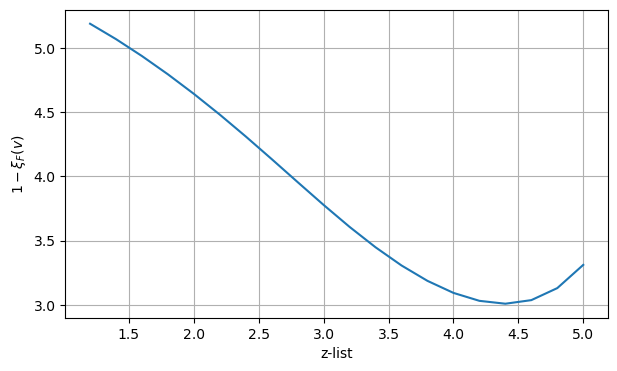

In [102]:
test = []
for j in z_list: 
    test.append(ghq_eq29(n=10, z=j, variance=variance_1d, v_field=gaussian_random_field, z0=3, a=58.6, b=-2.82))
    
plt.plot(z_list, test)
plt.xlabel('z-list')
plt.ylabel(r'$1 - \xi_F(v)$')
plt.grid(True)